# Pytorch paper replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch.

## Get Setup

In [1]:
import torch as pt
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchinfo
from torch import nn
import helper_functions
from torchvision import transforms

C:\Users\pwrxn\miniconda3\envs\pytorch\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Get data

We already have our data imported so we just need to divide our data for train/ test datasets

In [16]:
from pathlib import Path
# setup directories paths to trian and test images
train_dir = Path('data/pizza_steak_sushi/train')
test_dir = Path('data/pizza_steak_sushi/test')

In [17]:
train_dir

WindowsPath('data/pizza_steak_sushi/train')

## Create Datasets and Dataloaders

In [18]:
from going_modular import data_setup

# Create an image size
IMG_SIZE = 224

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [19]:
# Create a batch size of 32
BATCH_SIZE = 32

# Create DataLoader
train_dataloaders, test_dataloaders, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloaders), len(test_dataloaders), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [20]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloaders))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# veiw the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

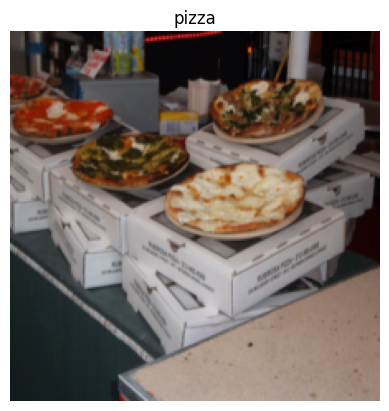

In [21]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## Replicating ViT: overview